### Monte Carlo Integration

check that $$\int_0^\infty dx \ x^3 \exp{\left(-\frac{x^2}{2\sigma^2}\right)} = 2\sigma^4$$


- Does the result converge with the number of samples? And how does the error go down?
- Do it many times. For a given N, how are the result distributed? We'll talk about model fitting at lenght later on, but for now try to fit it by hand with a parametrized model. (If N is large enough you should get something that looks very accurate! And if N is small?)
- How does the distribution change if N increases?

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import iminuit
from iminuit import Minuit
from iminuit import cost
from iminuit.cost import LeastSquares

In [2]:
# define function for x^3
def func(x):
    return x**3

# Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

In [3]:
# Useful variables
mu = 0  # mean for sampling function
sigma = 1

normal_factor = 1/2 * np.sqrt(2 * np.pi) * sigma  # 1/2 because the integral is between [0, +inf] instead between [-inf, +inf]
expected_value = 2 * sigma**4   # expected result of the integral


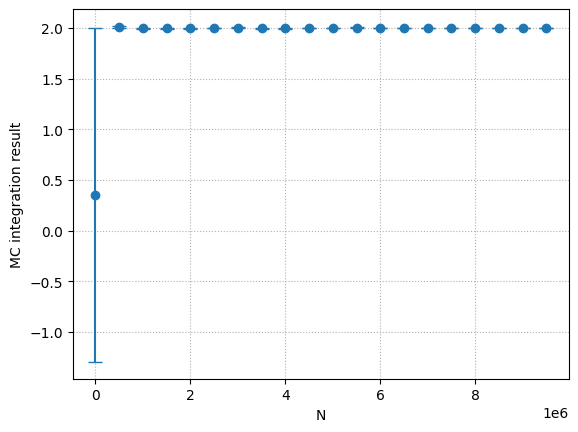

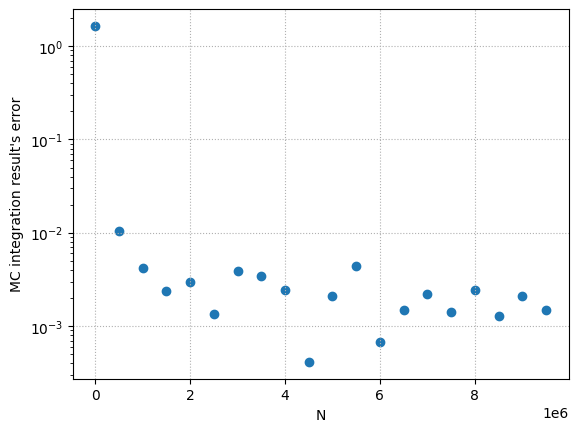

In [9]:
# sampling from a gaussian distribution
N = 10000000 # max number of sampling

sampling = []
integral = []
error = []

# Monte Carlo integration with increasing number of sampling
for n in range(10, N, int(N/20)):
    #print("Sampling: ", n)
    sampling.append(n)
    xi = abs(np.random.normal(mu, sigma, n))

    value = normal_factor * np.mean(func(xi))
    integral.append(value)
    error.append(abs(value - expected_value))
    #print("Integral: ", value)

# Plot of the results of the integral and its error as function of the number of samplig
plt.errorbar(sampling, integral, error, fmt='o', capsize=5)
plt.grid(linestyle=':')
plt.xlabel("N")
plt.ylabel("MC integration result")
plt.show()

plt.scatter(sampling, error, marker='o')
plt.yscale("log")
plt.grid(linestyle=':')
plt.xlabel("N")
plt.ylabel("MC integration result's error")
plt.show()


The result of Monte Carlo integration converge to the expected result and the error go down very fast

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 58.48 (χ²/ndof = 1.1)      │              Nfcn = 534              │
│ EDM = 1.25e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

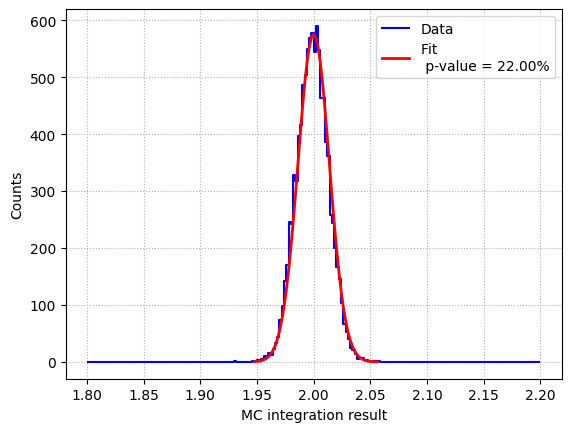

In [ ]:
# For a given N study the distribution of the result
N = 100000 # max number of sampling

integral = []
error = []

trial = 10000 # number of trial

# Monte Carlo integration with increasing number of sampling
for i in range(0, trial):
    xi = abs(np.random.normal(mu, sigma, N))

    value = normal_factor * np.mean(func(xi))
    integral.append(value)
    error.append(abs(value - expected_value))
    #print("Integral: ", value)

# Histogram of the result
bins = np.linspace(expected_value - 0.2, expected_value + 0.2, 200)
counts, bin_edges = np.histogram(integral, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
counts_err = np.sqrt(counts)  # Errore di Poisson

# Fit of the result distribution
# Fit region
xmin = np.min(bin_centers[counts > 0])
xmax = np.max(bin_centers[counts > 0])
mask = (bin_centers > xmin) & (bin_centers < xmax) & (counts > 0)
bin_centers_fit = bin_centers[mask]
counts_fit = counts[mask]
counts_err_fit = counts_err[mask]

# Cost function definition
least_squares = LeastSquares(bin_centers_fit, counts_fit, counts_err_fit, gaussian)

# Minuit initialization
m = Minuit(least_squares, A=max(counts), mu=expected_value, sigma=0.1)
m.limits["sigma"] = (0, None)  # Inferior limit for sigma
m.migrad()  # Minimize
m.hesse()   # Error comèputing
print(m)

# Gaussian fit
fit_values = gaussian(bin_centers_fit, m.values["A"], m.values["mu"], m.values["sigma"])

chi2_ = m.fval
dof = m.ndof
p_value = (1 - stats.chi2.cdf(chi2_, dof)) * 100

# Plot of the results of the integral and fit
plt.step(bin_centers, counts, label='Data', color='blue')
plt.plot(bin_centers_fit, fit_values, label=f'Fit \n p-value = {p_value:.2f}%', color='red', linewidth=2)
#plt.axvline(xmin, color="green", linestyle="--", label=f"xmin")
#plt.axvline(xmax, color="green", linestyle="--", label=f"xmin")
plt.legend()
plt.grid(linestyle=':')
plt.xlabel("MC integration result")
plt.ylabel("Counts")
plt.show()

At the increasing of N the distribution of the results reduce its standard deviation becoming more and more similar to a Dirac Delta.